# Data Cleaning & Feature Extraction

In this notebook, load the different data sources explored earlier and clean them for our approaches. We will then create a very basic predicition system to check for 

In [15]:
import pandas as pd
import numpy as np
import sys, os
from datetime import datetime
sys.path.insert(1, '..')
import recommender as rcmd
from matplotlib import pyplot as plt
%matplotlib inline

Next we will load a set of relevant data sources

In [2]:
nf = rcmd.news.FPNewsFeed('https://www.ft.com/business-education?format=rss', col_map={'link': 'article_link', 'summary': 'summary', 'title': 'headline', 'published': 'date'}, filter=True)
news_meta, df_news = nf.news()
sm = rcmd.stocks.FMPStatements()
tk = rcmd.stocks.AlphaVantageTicker()
df_stocks = rcmd.contrib.fmp_api.profile.list_symbols()

In [30]:
df_stocks['symbol'].values

array(['SPY', 'CMCSA', 'KMI', ..., 'ZWZZT', 'ZXZZT', 'ZYME'], dtype=object)

## Data Extraction Pipeline

Our goal will be to create a pipeline that can extract data for a specific stock we select from `df_stocks`. This includes the last balance-sheet statements as well as historic stock prices. We should also search for historic news that we can use for the training process.

In [38]:
def find_stock(name, stocks):
    return stocks[stocks['name'].str.contains(name, case=False)]

find_stock('facebook', df_stocks)

,name,price,symbol
21,Facebook Inc.,188.2,FB


In [57]:
# some stock selection functions (this gathers all available data and might take a while...)
#df = sm.merge_records(df_stocks['symbol'].values)
#df.to_csv('../data/statements.csv')

# load the relevant data
df = pd.read_csv('../data/statements.csv')

In [61]:
# create an index based on year and quarter
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter

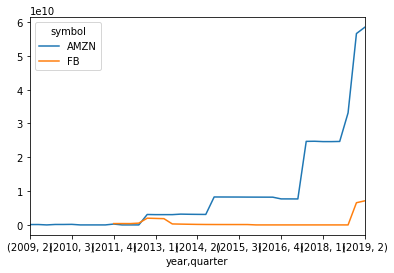

In [76]:
# print out example data
def get_feature(symbol, feat):
    return df[df['symbol'] == symbol].set_index(['year', 'quarter'])[feat].rename(symbol).sort_index(ascending=True)

def get_features(symbols, feat):
    return df[df['symbol'].isin(symbols)].pivot_table(index=['year', 'quarter'], columns='symbol', values=feat).sort_index(ascending=True)

# plot features
get_features(['FB', 'AMZN'], 'debt_longterm').plot()

**Stock Data**

Now that we have loaded the relevant Stock Statements, lets load the historical stock data (daily resolution) - in this case loading from file (requires that the `data/download_stocks.sh` script has been executed.

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


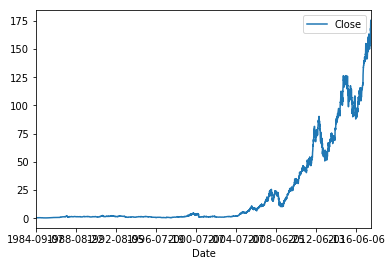

In [12]:
import glob
import os
def list_stocks(type='stock'):
    '''Generates a list of available historic stock data.'''
    fldr = 'Stocks' if type == 'stock' else 'ETFs'
    path = '../data/{}'.format(fldr)
    # list all fiels in direcotry
    files = glob.glob(os.path.join(path, '*.txt'))
    names = pd.Series(files).apply(lambda f: os.path.basename(f).split('.')[0])
    #return pd.DataFrame({'symbol': names, 'file': files})
    return dict(zip(names, files))

def load_stock_file(file, type='stock'):
    # list all fiels in direcotry
    return pd.read_csv(file)
    
stocks = list_stocks('stock')
#stocks
dfa = pd.read_csv(stocks['aapl'])
dfa.set_index('Date')[['Close']].plot();
dfa.head()

In [13]:
# sample list of stock elements
sample = np.random.choice(list(stocks.keys()), 30)
#sample = list(stocks.keys())[:10]

# Note: integrated into the cache class in the recommender
def load_stock_list(symbols, stocks=None, ticker=None):
    '''Loads a dataframe with the given stock data.
    
    Args:
        symbols (list): List of symbol names to load
        stocks (dict): Stock name dictionary (if None, load with default vals)
        
    Returns:
        DataFrame in default stock format with additional symbol column
    '''
    df_stocks = []
    for symbol in symbols:
        # load stock data
        if symbol in stocks:
            try:
                df_stock = pd.read_csv(stocks[symbol])
            except:
                continue
        else:
            try:
                df_stock = ticker.historic(symbol, start=None, resolution='daily').reset_index()
            except:
                print('Could not load {}'.format(symbol))
                continue
            
        # check if empty
        if df_stock is None or df_stock.empty == True:
            continue
        
        # add
        df_stock['symbol'] = symbol
        df_stock.columns = [col.lower() for col in df_stock.columns]
        df_stocks.append(df_stock)
    
    
    df = pd.concat(df_stocks, axis=0)
    return df

df_stocks = load_stock_list(sample, stocks, ticker=rcmd.stocks.AlphaVantageTicker())
df_stocks.sample(10)

,date,open,high,low,close,volume,openint,symbol
526,1987-07-31,5.6651,5.7698,5.6195,5.7698,2573557,0,lb
7386,2014-02-14,36.5070,37.1120,36.2110,37.0630,1120019,0,txt
77,2014-06-17,21.5460,21.6820,21.5370,21.6380,230091,0,vza
2722,2015-12-21,11.5310,11.5310,11.4280,11.4960,66168,0,nmy
3128,2017-08-01,12.8100,13.1400,12.7400,13.0500,221503,0,strl
2,2011-06-21,15.2400,15.3500,13.2700,13.5000,3317162,0,p
420,2006-10-25,8.4513,8.4993,8.4117,8.4993,70082,0,jbss
1238,2010-01-27,11.0670,11.0740,11.0580,11.0740,18563,0,nxp
326,2008-04-10,20.4750,20.6520,20.2800,20.5600,7844,0,pkw
8172,2015-11-11,149.4000,152.0100,148.8700,151.6000,680646,0,whr


In [ ]:
# TODO: select historic news and scrap entire news articles? + Use Embeddings to integrate them

## Feature Extraction

After we have loaded the data and can extract relevant portions, we want to convert it into training data. This requires data to have a single embedding and to use structured time information. As well as combine past data with future performance to have labels for the training process.

The goal of the stock prediction system is to use current information:

* Last Statements from a given company
* Recent stock history

To predict the outcome of the stock data (i.e. would an invest in the stock be profitable over time horizon X). This leaves us with the following parameters for the data training:

`1.` Time Horizon of prediction (How long do we want to look in the future?)

`2.` Amount of Recent Data (Do we just give the current state of a windows of data from the past X days/month?)

`3.` Cliping of target values (in which interval is a stock profitable, neutral or unprofitable?)

`3.` Normalization of the Data (Do we use absolute values of differences?)

`4.` Smoothing of the Data (Do we take the stock closing price on a single day or of a week?)

The last two questions are probably easiest to answer. Since all stocks have different values (i.e. different start prices of the stock and current statement values) and these values do not have an impact on our prediction (if a \\$10 stock rises to \\$200 this is a much better investment than a \\$1000 stocks rise to \\$1500). We will therefore adopt a normalization that takes the current stock price as a starting point and computes percental difference from there. This will provide a normalized scale across all stocks.

For the smoothing we might use a time windows that is dependent on the length of the prediction (e.g. +/- 3 days for a quarter prediction and +/- 1 Week for a year prediction).

To verify this, we will write a function to normalize the data and given a time horizon create a distribution of the target values.

In [166]:
# Function to align the statements of a company with the 
def normalize_window(df, days_back, days_target, smooth_interval):
    '''Normalizes the data in the given window and returns the values and the target
    
    Args:
        df (np.Array): Numpy Array that contains only one values column
        days_back (int): How many days of history data should be included
        days_target (int): How many days shoudl the target value lie ahead
        smooth_interval (int): Interval in days around the target value that is used for smoothing (if None use just target day)
        
    Returns:
        Numpy array that has the normalized data of length `days_back` and an additional datapoint with the target value
    '''
    # retrieve the normalized data
    norm = df[days_back - 1]
    df = np.divide(df, norm) - 1
    
    # retrieve the input stock values
    vals = df[:days_back]
    # TODO: might call additional compaction (e.g. only weekly data)
    
    # calculate the target value
    target_loc = days_back + days_target - 1
    if smooth_interval is None:
        target = df[target_loc]
    else:
        target = df[(target_loc - smooth_interval):(target_loc + smooth_interval + 1)].mean()
    
    # return result vector
    return np.concatenate([vals, [target]])
    
# alias for numpy function
as_strided = np.lib.stride_tricks.as_strided
    
def create_dataset(df, days_back, days_target, smooth_interval, value_col='close', jump_size=7):
    '''Creates a dataset from the given stock data.
    
    Args:
        df (DataFrame): DataFrame of stock prices. Each Row should contain these columns: `[symbol, date, values]`
        value_col (str): Name of the column that contains the relevant stock data
        days_back (int): How many days of history data should be included
        days_target (int): How many days shoudl the target value lie ahead
        smooth_interval (int): Interval in days around the target value that is used for smoothing
        jump_size (int): Number of days to jump between different data points
    
    Returns:
        DataFrame that should contain the relevant stock information. It contains the following columns: `[date, *data, target, symbol]`.
        `date` is thereby the starting date before the prediction.
        `data` are a list of columns from newest to oldest (number is defined by `days_back`)
           |------------------|----------------------------|
         date    data    date+days_back                 target
    '''
    # iterate through all symbols in the df
    symbols = df['symbol'].unique()
    # make sure that date column is converted
    if df['date'].dtype == 'object':
        df['date'] = df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
        
    # calculate window size and the column names
    win = days_back + days_target + (smooth_interval if smooth_interval is not None else 0)
    cols = ["day_{}".format(i+1) for i in range(days_back)] + ["target"]
    
    # order symbol-df for time and perform sliding window
    df_symbol = df['symbol'].str.lower()
    df_norm = []
    for symbol in symbols:
        # retrieve partial df
        df_sym = df[df_symbol == symbol.lower()].sort_values(by='date').set_index('date')[[value_col]]
        df_arr = np.copy(df_sym.to_numpy())
        
        # sliding window
        st = df_arr.strides   # number of bytes for as_stride to jump
        sz = np.ceil((len(df_arr) - (win-1)) / jump_size)
        if sz < 1: continue
        wnds = as_strided(df_arr, (int(sz), win), (st[0] * jump_size, st[1] * 1))

        # apply normalization
        df_res = np.apply_along_axis(lambda wnd: normalize_window(wnd, days_back, days_target, smooth_interval), axis=1, arr=wnds)
        df_res = pd.DataFrame(df_res)
        
        # add columns and index
        df_res.columns = cols
        df_res.index = df_sym.index[:-(win-1)][0::jump_size]
        df_res['symbol'] = symbol
        
        # add to result
        df_norm.append(df_res)
    
    # add data to target
    df_norm = pd.concat(df_norm, axis=0)
    
    return df_norm

# Note: functions are added into rcmd (`learning.preprocess`)

In [167]:
df_norm = create_dataset(df_stocks, 7, 30, 3)
df_norm.head()

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,target,symbol
date,,,,,,,,,
2007-05-10,-0.071562,0.037960,0.012747,-0.005824,-0.000717,-0.012814,0.0,-0.138684,jmp
2007-05-21,0.027589,0.020266,0.022852,-0.016845,-0.003632,-0.003632,0.0,-0.112264,jmp
2007-05-31,0.062941,0.055684,0.035327,0.011989,-0.011238,-0.017818,0.0,-0.094366,jmp
2007-06-11,0.025250,0.041651,0.037612,0.046383,0.013529,0.014491,0.0,-0.223161,jmp
2007-06-20,-0.004840,-0.021142,-0.002853,-0.019257,-0.034604,-0.040411,0.0,-0.286044,jmp


                data
2016-09-01  0.007160
2016-09-02  0.005404
2016-09-03  0.014320
2016-09-04  0.012583
2016-09-05  0.017928
2016-09-06 -0.001795
2016-09-07  0.000000
2016-10-08  0.031498
Reference Date: 2016-09-08 00:00:00 - Value: 5.2746


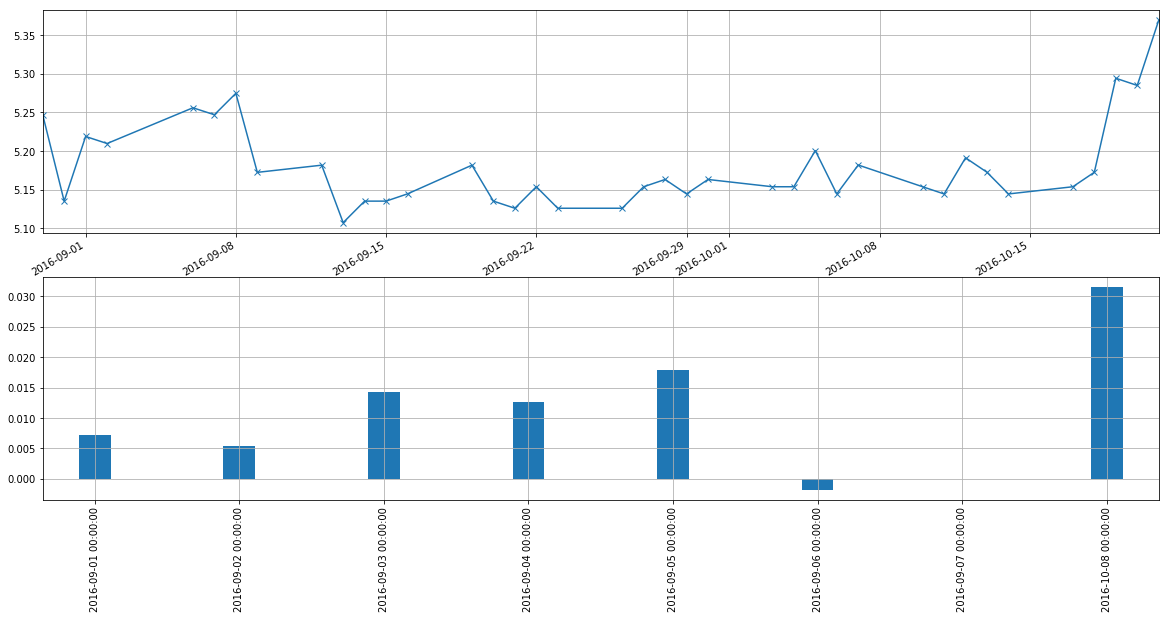

In [173]:
# visualize a stock of normalized data
def visualize(symbol, df_norm=df_norm, df_stocks=df_stocks):
    # retrieve relevant data
    dfn = df_norm[df_norm['symbol'] == symbol]
    dfs = df_stocks[df_stocks['symbol'] == symbol].set_index('date')['close']
    
    # helper
    days_back = 7
    days_target = 30
    smooth = 3
    
    # select data row
    dfn = dfn.sample(1).drop('symbol', axis=1)
    date = dfn.index[0]
    idx = [date + pd.DateOffset(i) for i in range(0, days_back)] + [date+pd.DateOffset(days_back+days_target)]
    dfn.columns = pd.to_datetime(idx)
    dfn = dfn.transpose()
    dfn.columns = ['data']
    print(dfn)
    
    # retrieve relevant stock data
    dfs = dfs[(dfs.index >= (idx[0] - pd.DateOffset(2))) & (dfs.index <= (idx[-1] + pd.DateOffset(smooth+10)))]
    #dfn.index = list(dfs.index[:days_back]) + list(dfs.index[-1:])

    date = date + pd.DateOffset(days_back)
    print("Reference Date: {} - Value: {}".format(date, dfs.loc[date]))
    
    # create two plots
    #dfs = dfs.reindex(index=dfs.index.union(dfn.index))
    #dfn = dfn.reindex(index=dfn.index.union(dfs.index))
    fig, axs = plt.subplots(2, 1, sharex=False, figsize=(20, 10))
    dfn.plot.bar(ax=axs[1], legend=None, grid=True, width=0.22)
    dfs.plot(ax=axs[0], legend=None, grid=True, marker='x')
    
    
    
visualize('jmp')

**Target Value Distributions**

Next we should understand what we actually want to measure. Therefore we will generate normalized training data in different strides and measure the distribution of target values. This will allow us to determine the smoothing and window parameter.

Since the target values are continuous, we have to use a bucketing approach (or density estimation based on a prior distribution) to identify relevant values. Due to computation power constraints, we will have to use a sub-sample of the the relevant stock data.

In [177]:
# load the entire df_stocks set
sample = np.random.choice(list(stocks.keys()), 1000)
df_stocks = load_stock_list(sample, stocks, ticker=rcmd.stocks.AlphaVantageTicker())

In [194]:
def get_target_dist(back, target, smooth, jump, df_stocks=df_stocks):
    '''Function to retrieve the target distribution of values from different parameters'''
    # calculate the dataset
    df_norm = create_dataset(df_stocks, back, target, smooth, jump_size=jump)
    
    # calculate + visualize (note generate different plots)
    fig, axs = plt.subplots(2, 1, figsize=(20, 5))
    df_norm['target'].plot.kde(xlim=(-5, 5), ax=axs[0])
    df_norm['target'].plot.hist(bins=100, ax=axs[1], range=(-5, 5))
    fig.suptitle('Dist: {} back - {} target - {} smoothing - {} jumps'.format(back, target, smooth, jump), fontsize=16)
    plt.show()
    
#get_target_dist(7, 30, 3, 7)

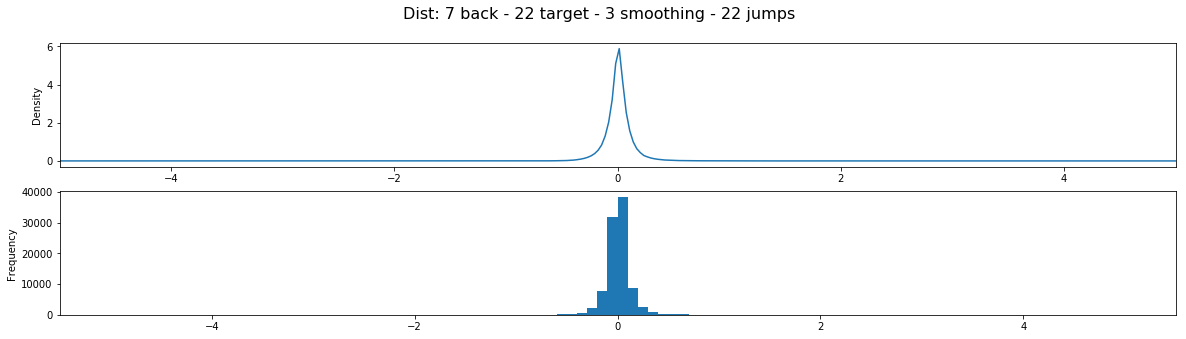

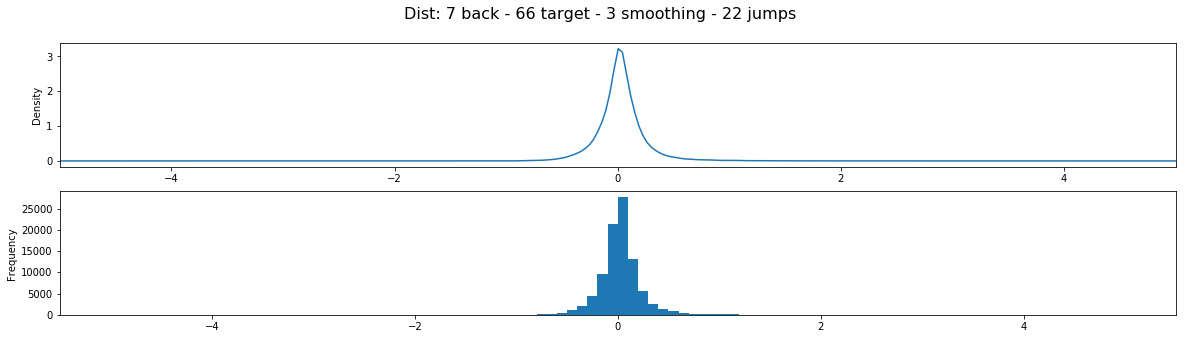

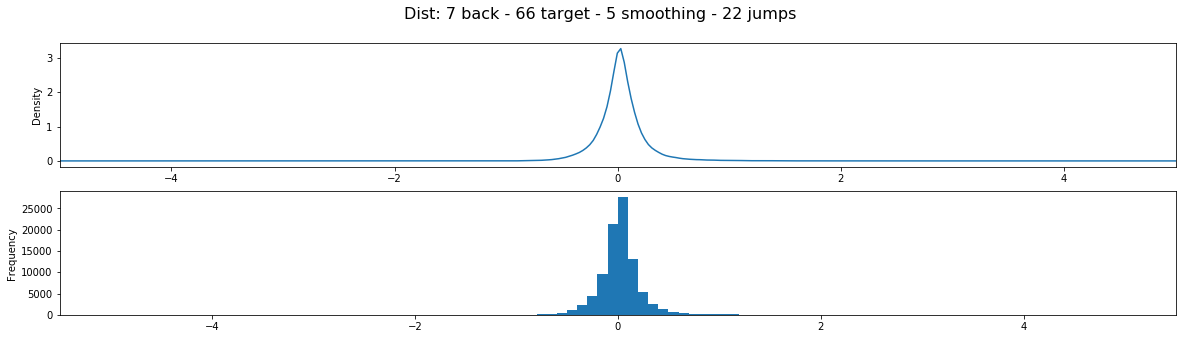

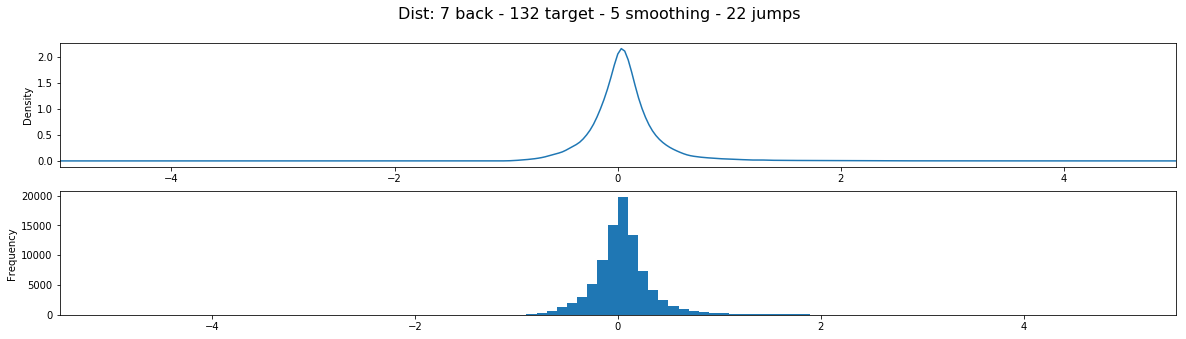

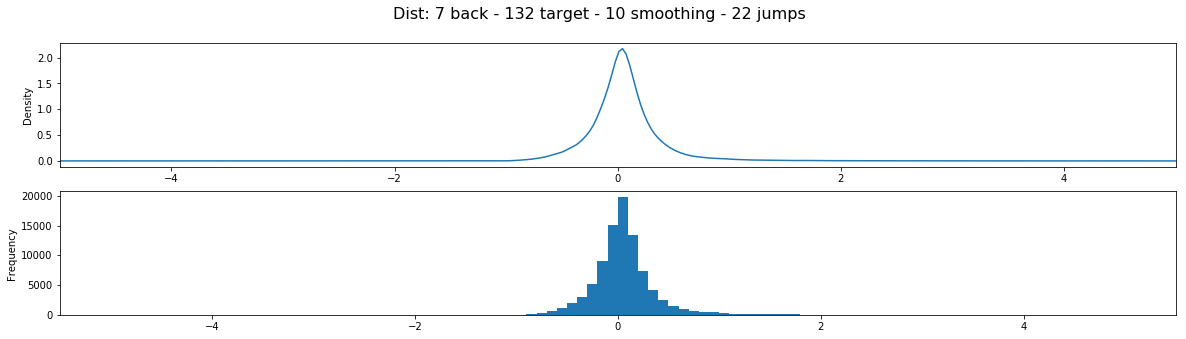

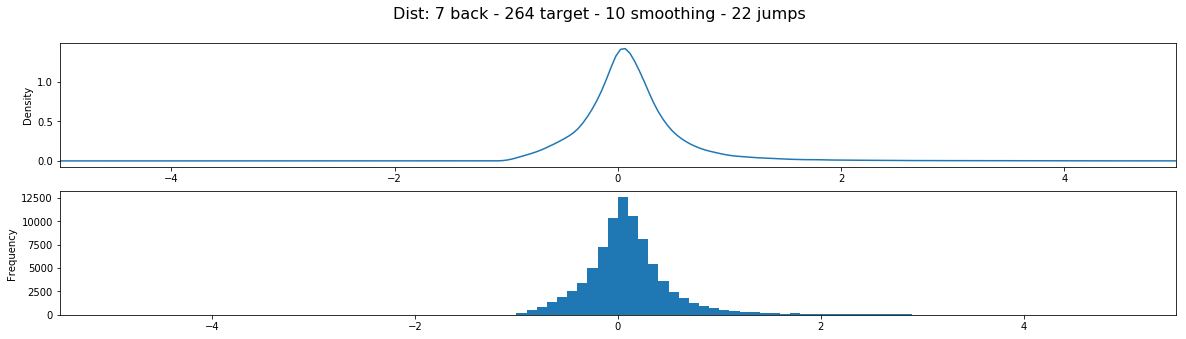

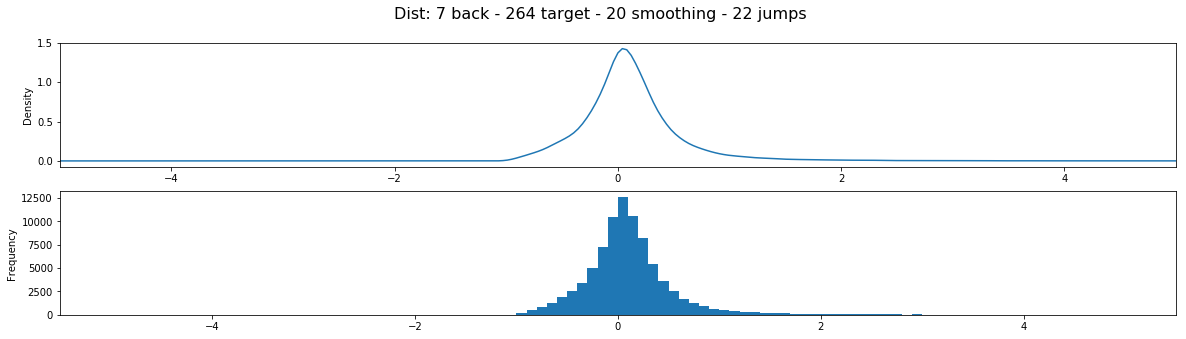

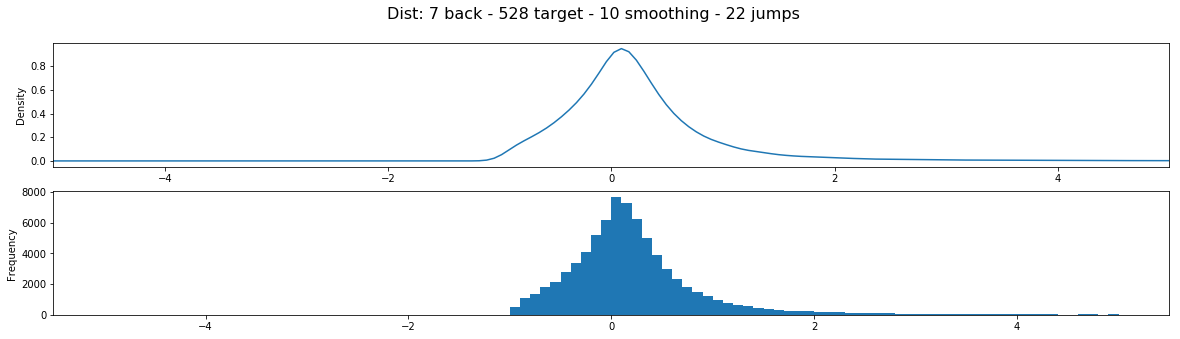

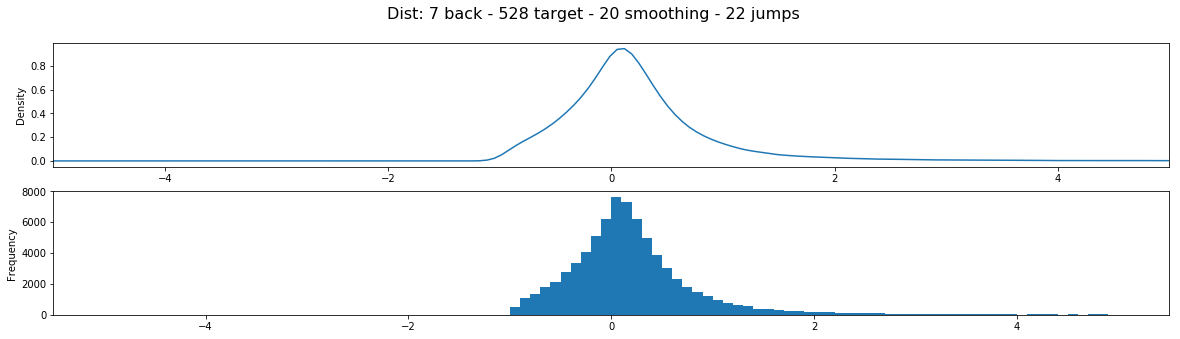

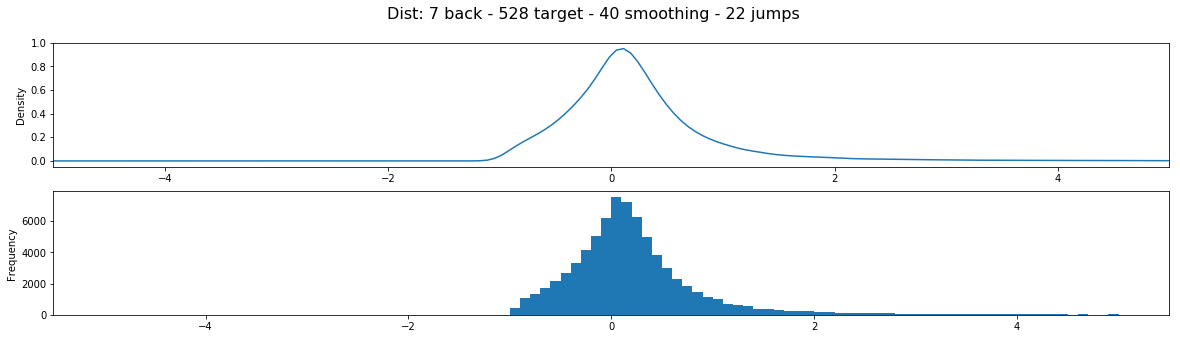

In [195]:
# generate distributions for various settings (expecting 22 work days per month)
jump = 22
sets = [
    (7, 22, 3, jump),
    (7, 22*3, 3, jump),
    (7, 22*3, 5, jump),
    (7, 22*6, 5, jump),
    (7, 22*6, 10, jump),
    (7, 22*12, 10, jump),
    (7, 22*12, 20, jump),
    (7, 22*24, 10, jump),
    (7, 22*24, 20, jump),
    (7, 22*24, 40, jump),
]

for s in sets:
    get_target_dist(s[0], s[1], s[2], s[3])

From the target value distribution, we can see multiple things:

* The distributions follows the pattern of a normal distribution centered around 0
* smoothing does not seem to have a notable impact
* We can see, that the distribution has higher variance as we look over longer time spans (as expected)
* As stocks cannot retrieve negative values, the negative part of the distribution cuts at -1 (which is a 100% value decline) - can be seen especially in the last distribution

This means that we will have to use adaptive value clipping based on the forcast length for the model we want to train. Our next steps will be to perform clipping and categorization of the values and look at the correlation matrix between different values to check for fundamental differences in the input data (i.e. is the historical input data actually suited to predict future prices)

[-0.5  -0.25  0.    0.25  0.5 ]


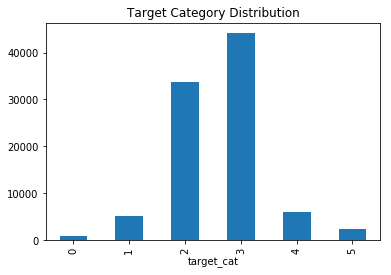

In [237]:
# function to perform categorization based on given limits
def categorize(df, xlim, num_cats=6):
    '''Performs categorization of the target values in the data.
    
    Args:
        df (DataFrame): DataFrame that contains the datapoints and a value of the target values
        xlim (tuple): tuple of limit values for the min and max values
        num (int): Number of categories to apply (2 categories are outer)
        
    Returns:
        DataFrame with update `target` column that contains int categorical value
    '''
    # define boundaries of categories
    d = (xlim[1] - xlim[0]) / (num_cats - 2)
    cats = np.array([xlim[0] + (d*i) for i in range(0, num_cats - 1)])
    print(cats)
    
    # update the target column
    df['target_cat'] = df['target'].clip(xlim[0], xlim[1]).apply(lambda x: num_cats - 1 if x == xlim[1] else np.where((cats >= x))[0][0])
    
    return df
    
# calculate the categories
df_norm = create_dataset(df_stocks, 7, 66, 3, jump_size=22)
df_cat = categorize(df_norm, xlim=(-0.5, 0.5), num_cats=6)

# visualize the categories
df_cat.groupby('target_cat').count()['symbol'].plot.bar(title='Target Category Distribution')

Now that we have categorized data, lets take a closer look at the correlation between the different categories (i.e. how different are input values for the actual target value - is there a high variance?)

In [226]:
# TODO: perform correlation test (through transpose multiplication)

# TODO

NameError: name 'num_cats' is not defined

TODO: discuss results